# History

**2021-11-05:**
- Initial version. New competition. No open tasks.

# Purpose

The objective of the **stage one** notebook is to analyze and understand the dataset and toidentify potential todos for data normalization, transformation, and feature selection. We also optimize the dataframes to reduce storage and memory usage.

# Setup environment

## Import basic modules

In [1]:
import os # for cpu count
import configparser # to load standard config.ini
import pandas as pd
import matplotlib.pyplot as plt
from typing import List # for dataframe optimization

%load_ext watermark
%matplotlib inline


## Define parameters

In [2]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

# Paths
PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "01_load-analyze-optimize" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)


Number of CPUs used: 16


# Load data

In [3]:
df_train = pd.read_csv(PATH_DATA_RAW+'train.csv') # for EDA and optimization
df_test = pd.read_csv(PATH_DATA_RAW+'test.csv') # for optimization only

# Review dataframe details

In [4]:
df_train.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float64(100), int64(2)
memory usage: 466.9 MB


In [6]:
#df_train.select_dtypes(exclude=['float64'])
#df_train.select_dtypes(exclude=['int64'])

# Review data distribution

## Review Features of dtype "float64"

In [7]:
df_train_float64 = df_train.drop(['id','target'], axis=1).select_dtypes(exclude=['int64'])
df_train_num_features = df_train_float64.columns
df_train_num_features.to_frame(name='num_features').sort_values('num_features').to_csv(PATH_DATA_INT+'num_features.csv', index=False)

### Describe

In [8]:
df_train_float64.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,600000.0,0.306508,0.522450,-3.79745,0.026222,0.097788,0.397184,8.78150
f1,600000.0,2.497590,1.554018,-1.22396,1.186237,2.516500,3.787630,6.22672
f2,600000.0,306.644536,551.743893,-1842.53000,43.573400,133.626000,302.262250,6119.28000
f3,600000.0,2.647901,1.544529,-1.36856,1.442028,2.634130,3.907640,6.52115
f4,600000.0,0.177850,0.417488,-3.20621,0.019709,0.061586,0.112712,8.26547
...,...,...,...,...,...,...,...,...
f95,600000.0,0.106419,0.209128,-1.27654,0.025461,0.062151,0.102016,3.65722
f96,600000.0,2.547853,1.558427,-1.58474,1.247888,2.601940,3.820665,6.25436
f97,600000.0,2.590159,1.525091,-1.25473,1.348078,2.682090,3.839520,6.14530
f98,600000.0,0.158881,0.436190,-3.99350,0.013536,0.058058,0.110718,10.76700


In [9]:
df_train_float64.describe().T['max'].value_counts()

8.78150     1
10.86660    1
1.70414     1
9.91994     1
6.51642     1
           ..
5.45127     1
6.54294     1
9.02117     1
3.75236     1
5.98811     1
Name: max, Length: 100, dtype: int64

### Histogram

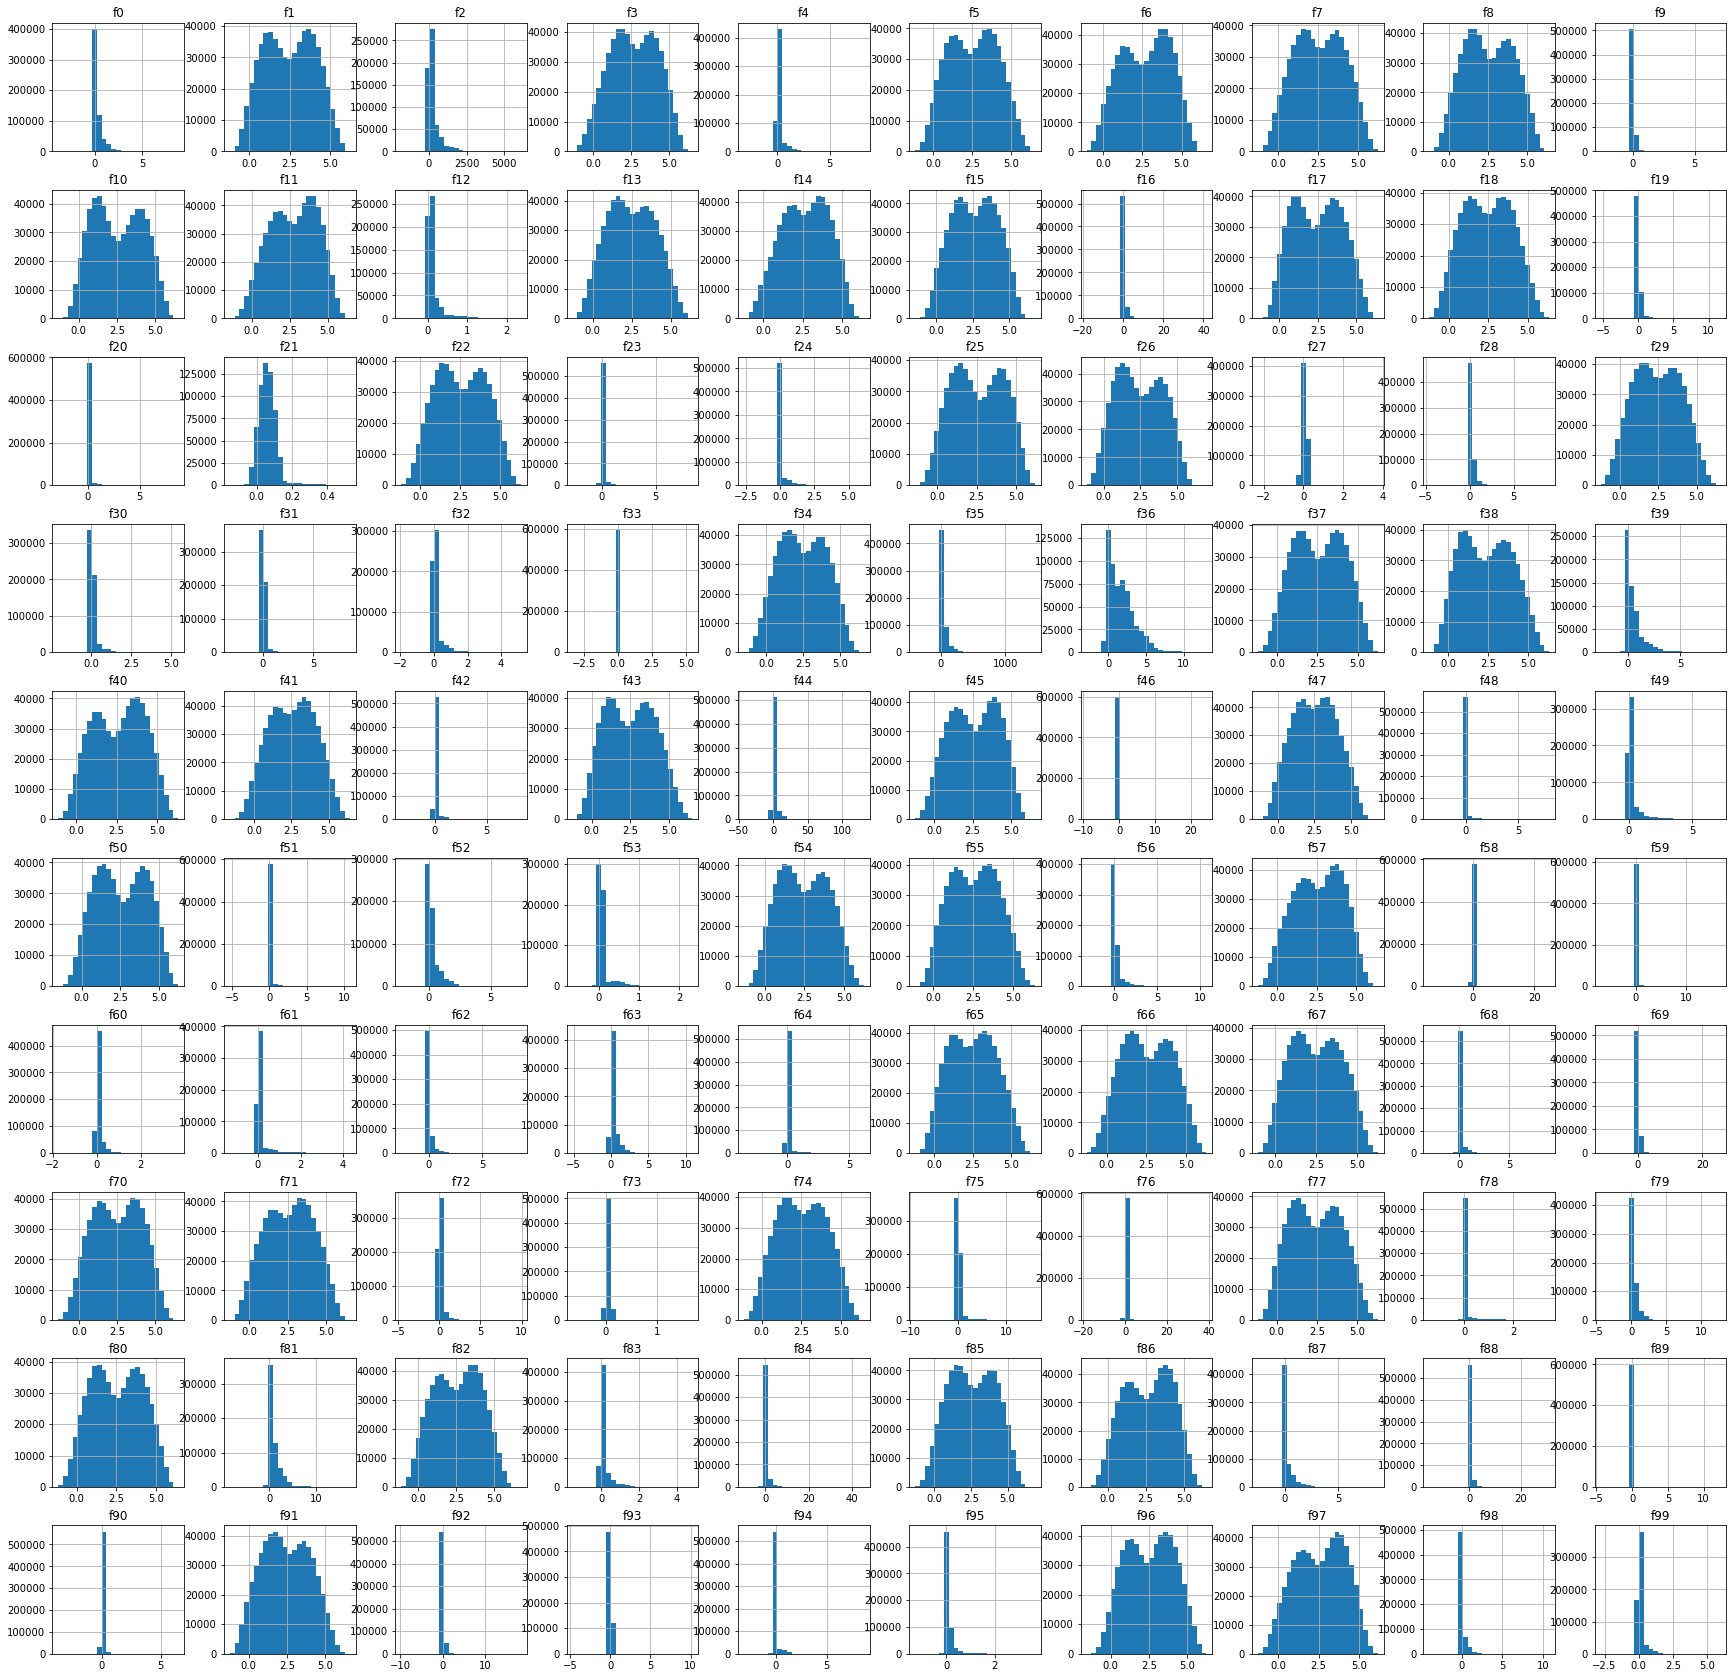

In [10]:
df_train_float64.hist(bins=25, figsize=(30,30))
plt.show()

### Skewness 

Checking skewness based on histograms.

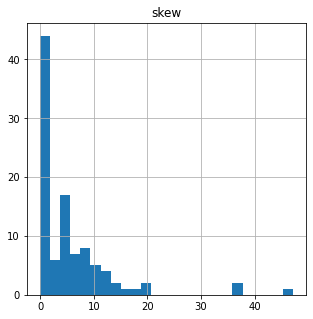

In [11]:
# skewness along the index axis
df_train_float64.skew(axis = 0, skipna = True).to_frame('skew').hist(bins=25, figsize=(5,5))
plt.show()

### Correlation 

In [12]:
#corr = df_train_float64.corr()
#corr.style.background_gradient(cmap='coolwarm')

### Conclusion
- All features have the same range/scale between 0 and 1. Normalization does not seem necessary.
- Remove features with less data (low variance).
- Some features are highly skewed.


In [13]:
# TODO: **Discard features that have low variance.**
# TODO: **Transform (Power Transform) features to address skewness.**

TODO: Transform (Power Transform) features.

## Review features of dtype "int64"

In [21]:
# int64 is just the id and target column
#df_train_int64 = df_train.drop(['id','target'], axis=1).select_dtypes(exclude=['float64'])

In [22]:
df_train_int64.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Empty DataFrame

In [23]:
#df_train_cat_features = df_train_int64.columns
#df_train_cat_features.to_frame(name='cat_features').sort_values('cat_features').to_csv(PATH_DATA_INT+'cat_features.csv', index=False)

### Describe

In [24]:
#df_train_int64.describe().T

In [25]:
#df_train_int64.describe().T['max'].value_counts()

### Histogram

In [26]:
#df_train_int64.hist(bins=25, figsize=(30,30))
#plt.show()

### Correlation

In [27]:
#corr = df_train_int64.corr()
#corr.style.background_gradient(cmap='coolwarm', axis=None)

In [28]:
"""
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(3))
"""

"\n# Fill diagonal and upper half with NaNs\nmask = np.zeros_like(corr, dtype=bool)\nmask[np.triu_indices_from(mask)] = True\ncorr[mask] = np.nan\n(corr\n .style\n .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)\n .highlight_null(null_color='#f1f1f1')  # Color NaNs grey\n .set_precision(3))\n"

## Review target value

In [29]:
df_train['target'].value_counts()

1    303606
0    296394
Name: target, dtype: int64

### Conclusion
- Target values point to **classification** problem (0 or 1).
- The target is almost evenly distributed between the two classes. **No imbalance.**

# Optimize and save dataframes

## Optimize memory (and space) usage

In [30]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=["float64"]).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast="float")
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=["int64"]).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast="integer")
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=["object"]):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype("category")
        else:
            df[col] = pd.to_datetime(df[col])
    return df


def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


In [31]:
df_train = optimize(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float32(100), int32(1), int8(1)
memory usage: 231.7 MB


In [32]:
df_test = optimize(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Columns: 101 entries, id to f99
dtypes: float32(100), int32(1)
memory usage: 208.1 MB


## Save optimize dataframes

In [33]:
# opt for optimized
FILENAME = "train-opt.pkl"
df_train.to_pickle(PATH_DATA_INT + FILENAME)

FILENAME = "test-opt.pkl"
df_test.to_pickle(PATH_DATA_INT + FILENAME)


# Watermark

In [34]:
%watermark

Last updated: 2021-11-05T23:34:54.414511+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [35]:
%watermark --iversions

sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.4.3
pandas    : 1.3.4

